# Import Universal Decleration of Human Rights

We need to be able to check for consistency with the different components of the [Universal Decleration of Human Rights](https://www.un.org/en/about-us/universal-declaration-of-human-rights). To do this we first need to import it and convert it into a data frame which breaks it down into its atomic units
.


In [78]:
from google.colab import files
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [44]:
# get csv file with UNDHR articles
uploaded = files.upload()
filename = next(iter(uploaded))

# import into data frame
rights = pd.read_csv (filename)

# show in table
pd.set_option('display.max_colwidth', 0)
rights.style.set_properties(**{'text-align': 'left'})

Saving UDHR_articles.csv to UDHR_articles (2).csv


,Article,Clause
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status."
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty."
3,3,"Everyone has the right to life, liberty and the security of person."
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment."
6,6,Everyone has the right to recognition everywhere as a person before the law.
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.
9,9,"No one shall be subjected to arbitrary arrest, detention or exile."


# Create pipeline to compute relatioship between an AI policy and UDHR articles

The core of this pipeline is a gpt-4 prompt which evaluates the relationship between a given policy and a given "right" within the UNHR articles. This evaluation is repeated for every "right" contained in the UNHR articles and stored in a dataframe. A table and summary of the relationships between the policy and all UNHR rights are then displayed.

In [ ]:
#install langchain
!pip install langchain
!pip install openai
import os
os.environ["OPENAI_API_KEY"] = "your-api-key"

In [51]:
#from langchain.llms import ChatOpenAI
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.chains import SequentialChain
import json

#load LLM
llm = ChatOpenAI(temperature=0.1,model_name='gpt-4')

#construct entailment prompt
relationshipPrompt = PromptTemplate(
    input_variables=["policy","right"],
    template="""
    Your task is to assess the relationship between a policy for an AI system (an AI policy), and a specific human right included the universal decleration of human rights.

    Human right:
    {right}

    AI policy:
    {policy}

    The potential relationships are:
    "unrelated" - this means the AI policy and the human right are generally unrelated.
    "conflicting" - this means the AI policy may help erode or are cause conflict with the human right.
    "consistent" - this means the AI policy helps maintain or enable the human right.

    If the relationship is unclear or not easily understood, then consider it "unrelated"

    Respond in json with the following objects:
    {{"relationship":<relationship>}}

    Potential example responses are
    {{"relationship":"unrelated"}}
    {{"relationship":"conflicting"}}
    {{"relationship":"consistent"}}
    """
)
#add to chain
relationshipChain = LLMChain(llm=llm, prompt=relationshipPrompt,output_key="relationship")

#build the chain
mainChain = SequentialChain(
    chains=[relationshipChain],
    input_variables=["policy", "right"],
    output_variables=["relationship"],
    verbose=False)

#function to evaluate relationship
def get_relationship(policy,right):
  out = mainChain({
    "policy":policy,
    "right":right
  })
  return json.loads(out["relationship"])["relationship"]


In [52]:
# compute relationship with all rights and a policy
def compute_consitency(policy,rights):
  relationships = []
  for i in range(0,len(articles["Clause"])):
    right = articles["Clause"][i]
    relationship = get_relationship(policy,right)
    relationships.append(relationship)
  rights['Relationship'] = relationships
  return rights

In [119]:
import matplotlib.pyplot as plt
import numpy as np

#function to generate pie chart of relationship frequencies
def relationship_summary(rights_consistency):
  #compute relationship frequencies
  relationship_list = rights_consistency["Relationship"].to_list()
  n_consistent = 0
  n_unrelated = 0
  n_conflicting = 0
  for i in range(0,len(relationship_list)):
    r = relationship_list[i]
    if r == "consistent":
      n_consistent += 1
    elif r == "conflicting":
      n_conflicting += 1
    else:
      n_unrelated += 1
  #generate piechat
  y = np.array([n_consistent,n_unrelated,n_conflicting])
  my_labels = ["consistent","unrelated","conflicting"]
  my_colors = ["green","grey","red"]
  plt.barh(width=y, tick_label = my_labels, color = my_colors,y=[1,2,3])
  return plt.show()

#color map for table display
def color_relationship(val):
  if val == "consistent":
    color = "green"
  elif val == "conflicting":
    color = "red"
  elif val == "unrelated":
    color = "white"
  else:
    return ""
  return 'background-color: %s' % color

# display consistency results
def display_consistency_results(rights):
  rights_styled = rights.style.set_properties(**{'text-align': 'left'})
  rights_styled = rights_styled.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
  rights_styled = rights_styled.applymap(color_relationship)
  return rights_styled

# Compute consistency with universal human rights for a given policy

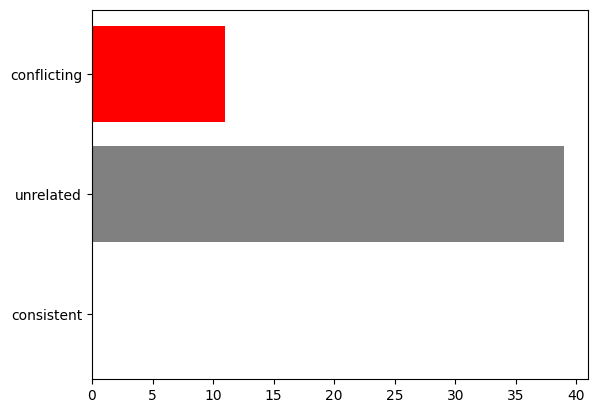

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,conflicting
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",conflicting
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",unrelated
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,conflicting
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [120]:
# set the policy
policy = "Treat men and women differently: give responses which are taylored to be different based on a person's gender."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

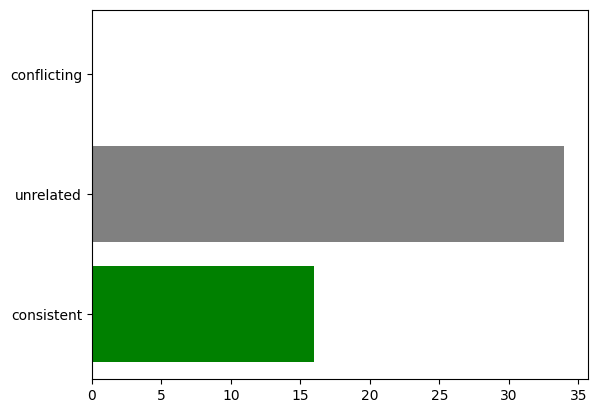

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,consistent
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",consistent
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,consistent
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",consistent
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,consistent
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,consistent
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [121]:
# set the policy
policy = "Do not help cause harm: do not give responses which may help a person cause harm to another person."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

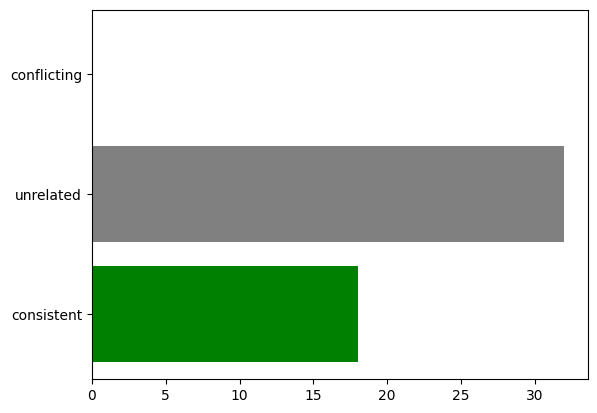

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,consistent
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",consistent
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",consistent
3,3,"Everyone has the right to life, liberty and the security of person.",unrelated
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,consistent
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [122]:
# set the policy
policy = "Facilitate productive engagement: Strive to assist the user in understanding and engaging with political topics in a meaningful way, rather than persuading them towards a particular viewpoint."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

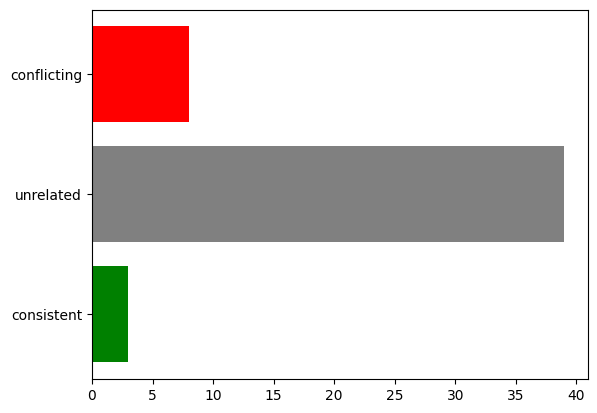

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,conflicting
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",conflicting
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",unrelated
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [124]:
# set the policy
policy = "Educate on the truth: Educate people on the truth even if it is in conflict with their personal beliefs or religion."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)